In [ ]:
import os
os.chdir("Your path")

### Try using SCVI (abandoed since it is no suit for PANCREAS dataset)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_5484\1078881891.py:27: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata2, adata3, batch_key="batch", batch_categories=["293T", "Jurkat", "half"])


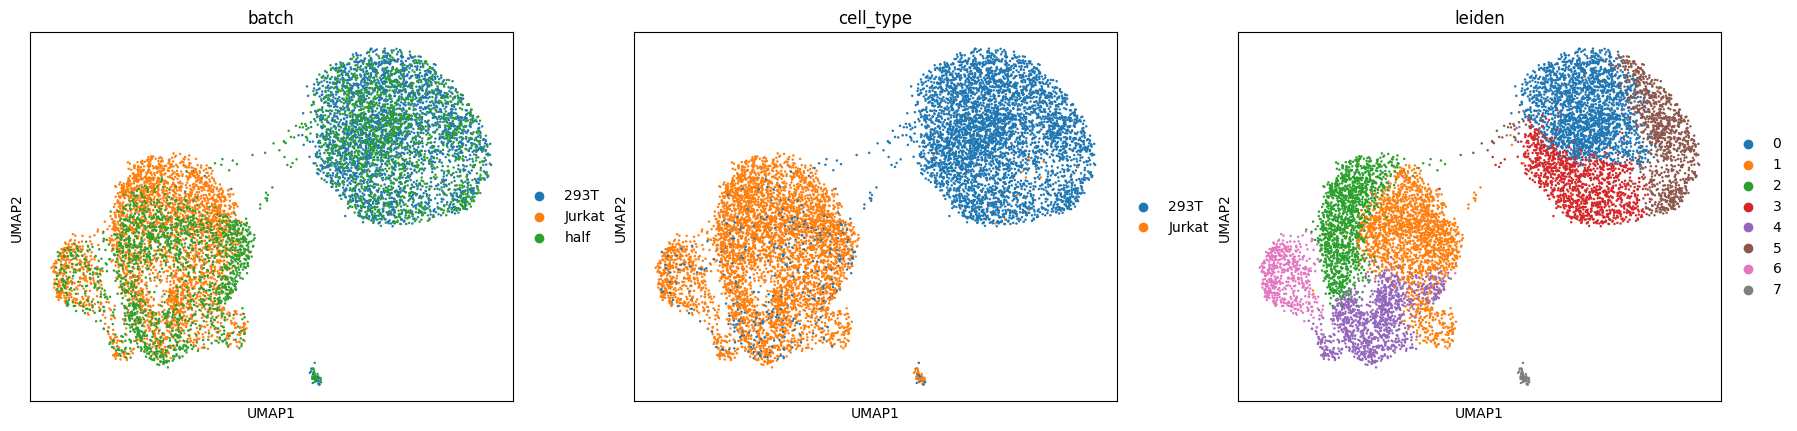

In [ ]:
import scanpy as sc
import pandas as pd
import bbknn


def load_10x_mtx(path, batch_label):
    adata = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    adata.obs['batch'] = batch_label
    adata.var_names_make_unique()
    return adata

adata1 = load_10x_mtx("293t_filtered_gene_bc_matrices/", "293T")
adata2 = load_10x_mtx("jurkat_filtered_gene_bc_matrices/", "Jurkat")
adata3 = load_10x_mtx("jurkat_293t_50_50_filtered_gene_bc_matrices/", "half")


all_data = [adata1, adata2, adata3]

for adata in all_data:
    if "XIST" in adata.var_names:
        xist_expr = adata[:, "XIST"].X.toarray().flatten()
        adata.obs["cell_type"] = ["293T" if x > 0 else "Jurkat" for x in xist_expr]
    else:
        adata.obs["cell_type"] = "unknown"


adata = adata1.concatenate(adata2, adata3, batch_key="batch", batch_categories=["293T", "Jurkat", "half"])


if "XIST" in adata.var_names:
    xist_expr = adata[:, "XIST"].X.toarray().flatten()
    adata.obs["cell_type"] = ["293T" if x > 0 else "Jurkat" for x in xist_expr]
else:
    adata.obs["cell_type"] = "unknown"

# Normalization & Log transform for BBKNN
sc.pp.normalize_total(adata, target_sum=1e4)   # CPM normalization
sc.pp.log1p(adata)                             # log(1 + x)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# PCA + BBKNN integration
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
bbknn.bbknn(adata, batch_key="batch")

sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

#Visualization 
sc.pl.umap(adata, color=["batch", "cell_type", "leiden"])


adata.obs.to_csv("meta_data.csv")

pcs = pd.DataFrame(
    adata.obsm["X_pca"],
    index=adata.obs_names,
    columns=[f"PC{i+1}" for i in range(adata.obsm["X_pca"].shape[1])]
)
pcs.to_csv("scaled_pcs.csv")


### PANCREAS DATA integration 

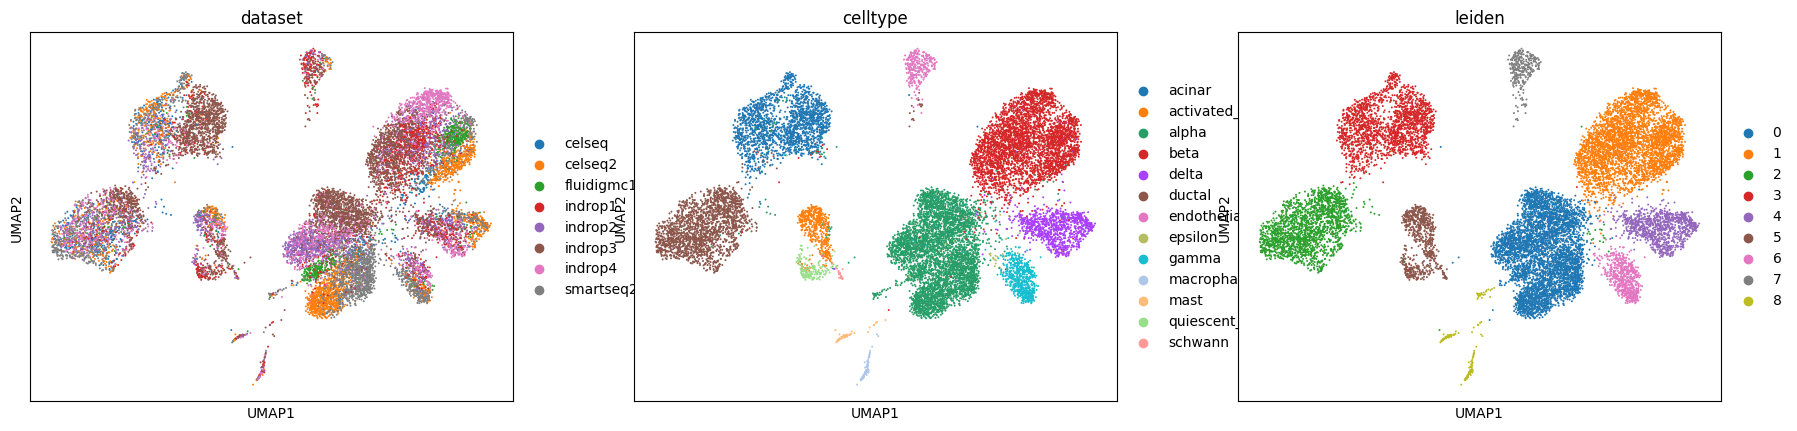

In [ ]:
import scanpy as sc
import bbknn

# Step 1
adata = sc.read("panc8.h5ad")

# Step 2
sc.tl.pca(adata, svd_solver='arpack')

# Step 3: Run BBKNN 
# Get batch key（ 'batch' or 'tech'）
bbknn.bbknn(adata, batch_key='dataset')

sc.tl.umap(adata)                 # UMA
sc.tl.leiden(adata, resolution=0.5)  # culster

# Step 5
sc.pl.umap(adata, color=['dataset', 'celltype', 'leiden'])


### Output cell_line for down stream benchmarking

In [ ]:
import scanpy as sc
import pandas as pd


meta_data = adata.obs.copy()
meta_data.to_csv("meta_data_BBKNN_PANC8.csv")


pcs = pd.DataFrame(
    adata.obsm["X_pca"],
    index=adata.obs_names,
    columns=[f"PC{i+1}" for i in range(adata.obsm["X_pca"].shape[1])]
)
pcs.to_csv("scaled_pcs_BBKNN_PANC8.csv")

print("meta_data.csv and scaled_pcs.csv saved successfully!")



✅ meta_data.csv and scaled_pcs.csv saved successfully!


### Using BBKNN in 239T_Jurkat Dataset

In [ ]:
import scanpy as sc
import scvi
import pandas as pd
import anndata

def load_10x_mtx(path, batch_label):
    adata = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    adata.obs['batch'] = batch_label
    adata.var_names_make_unique()
    return adata

adata1 = load_10x_mtx("293t_filtered_gene_bc_matrices/", "293T")
adata2 = load_10x_mtx("jurkat_filtered_gene_bc_matrices/", "Jurkat")
adata3 = load_10x_mtx("jurkat_293t_50_50_filtered_gene_bc_matrices/", "half")


all_data = [adata1, adata2, adata3]

for adata in all_data:
    if "XIST" in adata.var_names:
        xist_expr = adata[:, "XIST"].X.toarray().flatten()
        adata.obs["cell_type"] = ["293T" if x > 0 else "Jurkat" for x in xist_expr]
    else:
        adata.obs["cell_type"] = "unknown"


adata = adata1.concatenate(adata2, adata3, batch_key="batch", batch_categories=["293T", "Jurkat", "half"])


if "XIST" in adata.var_names:
    xist_expr = adata[:, "XIST"].X.toarray().flatten()
    adata.obs["cell_type"] = ["293T" if x > 0 else "Jurkat" for x in xist_expr]
else:
    adata.obs["cell_type"] = "unknown"


scvi.model.SCVI.setup_anndata(adata, batch_key="batch",labels_key="cell_type")
model = scvi.model.SCVI(adata)
model.train()


C:\Users\Samuel\AppData\Local\Temp\ipykernel_30252\221659547.py:29: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata2, adata3, batch_key="batch", batch_categories=["293T", "Jurkat", "half"])
C:\Users\Samuel\AppData\Roaming\Python\Python312\site-packages\scvi\dataloaders\_data_splitting.py:258: UserWarning: 2 cells moved from training set to validation set. if you want to avoid it please use train_size parameter during train.
  self.n_train, self.n_val = validate_data_split(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Samuel\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does

Epoch 400/400: 100%|██████████| 400/400 [12:10<00:00,  1.65s/it, v_num=1, train_loss_step=8.59e+3, train_loss_epoch=8.5e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [12:10<00:00,  1.83s/it, v_num=1, train_loss_step=8.59e+3, train_loss_epoch=8.5e+3]
